In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import ephem
import math
from datetime import timedelta
import matplotlib.dates as mdates

from datetime import datetime
from dateutil.relativedelta import relativedelta


### Read in the shadow dat
import glob
import calendar



In [50]:
def calculate_solar_cos_zenith(datetime_obj):
    observer = ephem.Observer()
    latitude  = 38.980762    # ERW
    longitude = -107.005017  # ERW
    observer.lat = str(latitude)
    observer.lon = str(longitude)
    observer.date = datetime_obj
    
    sun = ephem.Sun(observer)
    solar_altitude = sun.alt

    # Calculate zenith angle (90 degrees - solar altitude)
    zenith_angle = math.pi / 2.0 - solar_altitude

    # Calculate cosine of zenith angle
    cos_zenith = math.cos(zenith_angle)

    return cos_zenith

In [51]:
master_df = pd.read_csv("/global/homes/r/rudisill/gshare2/will_data/crf_files/master_df_sail_cre.csv", index_col=0, parse_dates=True)                        

In [52]:
master_df['month'] = master_df.index.month

In [53]:
master_df['hour'] = master_df.index.hour
master_df['month'] =master_df.index.month

In [54]:
master_df['cza'] = master_df.index.map(calculate_solar_cos_zenith)

In [55]:
master_df['counter'] = 1

### make an algorithm to decompose the swdown

In [56]:
def round_to_nearest_multiple_of_10(number):
    return int(round(number / 10) * 10)


In [57]:
kolias = xr.open_dataset("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/kollias/cbh_kolias2.nc").to_pandas()
cloud_present_kolias = kolias.copy()
cloud_present_kolias[cloud_present_kolias == -1] = 0
cloud_present_kolias[cloud_present_kolias > 0] = 1


kolias_lt_4000 = kolias.where(kolias < 6000)
kolias_lt_4000.fillna(-1, inplace=True)
cloud_present_kolias_lt_6000 = kolias_lt_4000.copy()
cloud_present_kolias_lt_6000[cloud_present_kolias_lt_6000 == -1] = 0
cloud_present_kolias_lt_6000[cloud_present_kolias_lt_6000 > 0] = 1

master_df['cloud_present'] = cloud_present_kolias_lt_6000.resample("1h").mean().reindex(master_df.index) * 100

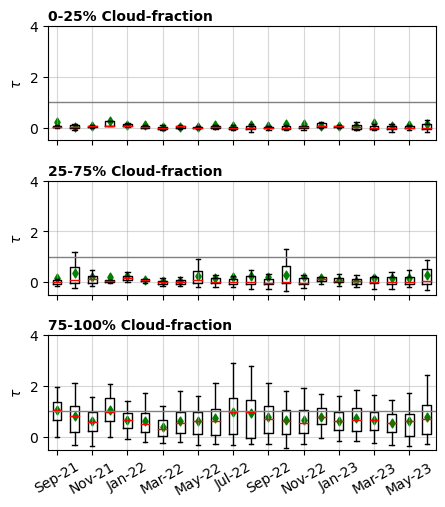

In [58]:
def tau_by_threshold(df, cloud_threshold0, cloud_threshold1):
    x0  = df.where((df.cloud_present > cloud_threshold0) & (df.cloud_present <= cloud_threshold1))
    x0 = x0.where(df.shadow==0).where(df.cza > .3)
    cld0 = -1*np.log(x0.qcrad_swd/x0.rrtmg_swd_clear)
    ncld = len(x0.counter.dropna())/len(df.counter.where(df.shadow==0).dropna())
    return cld0, ncld


fig,ax = plt.subplots(3,1,figsize=(5,5.5), sharex=True)
# ax21 = ax[0].twinx()
# ax22 = ax[1].twinx()
# ax23 = ax[2].twinx()

k=0
median_list = []

low_cld_tau = []
mid_cld_tau = []
hih_cld_tau = []
clear_tau = []

for gp in master_df.resample("m"):
    # make the clear sky transmissivity
    # cskt = -1*np.log(gp[1].where(gp[1].shadow ==1).rrtmg_swd_clear / gp[1].where(gp[1].shadow ==1).rrtmg_swd_toa)
    # ax[0].boxplot(cskt.dropna(), positions=[k], showfliers=False, widths=.5, showmeans=True, whis=1, medianprops=dict(color='red'))
    # clear_tau.append(cskt.dropna().mean())
    
    cld0, ncld = tau_by_threshold(gp[1], 0, 25)
 #   ax21.bar(k,  ncld*100, width=.5,  color='purple', alpha=.3)
    ax[0].boxplot(cld0.dropna(), positions=[k], showfliers=False, widths=.5, showmeans=False, whis=1, medianprops=dict(color='red'))
    ax[0].scatter(k, np.mean(cld0.dropna()), color='green', marker='d', s=20)
    low_cld_tau.append(cld0.dropna().mean() * ncld)


    cld0, ncld1 = tau_by_threshold(gp[1], 25, 75)
#    ax22.bar(k,  ncld1*100, width=.5,  color='purple', alpha=.3)
    ax[1].boxplot(cld0.dropna(), positions=[k], showfliers=False, widths=.5, showmeans=False, whis=1, medianprops=dict(color='red'))
    ax[1].scatter(k, np.mean(cld0.dropna()), color='green', marker='d', s=20)
    mid_cld_tau.append(cld0.dropna().mean() * ncld1)


    cld0, ncld2 = tau_by_threshold(gp[1], 75,101)
 #   ax23.bar(k,  ncld2*100, width=.5,  color='purple', alpha=.3)
    ax[2].boxplot(cld0.dropna(), positions=[k], showfliers=False, widths=.5, showmeans=False, whis=1, medianprops=dict(color='red'))
    ax[2].scatter(k, np.mean(cld0.dropna()), color='green', marker='d', s=20)
    hih_cld_tau.append(cld0.dropna().mean() * ncld2)

    
    k+=1



for axx in ax.flatten()[1:]:
    axx.set_xticks(np.arange(0,22,2))
    axx.set_ylim(-.5,4)
#    axx.set_yticks([0, .2, .4, .6, .8, 1., 1.2])
    axx.grid(alpha=.5)
    axx.axhline(1, color='gray', linewidth=1.)
    axx.set_ylabel(r"$\tau$", fontweight=16)


for axx in [ax[0]]:
    axx.set_xticks(np.arange(0,22,2))
    axx.set_ylim(-.5, 4)
#    axx.set_yticks([0, .2, .4, .6, .8, 1., 1.2])
    axx.grid(alpha=.5)
    axx.axhline(1, color='gray', linewidth=1.)
    axx.set_ylabel(r"$\tau$", fontweight=16)


# for axx in [ax21, ax22, ax23]:
#     axx.set_ylim(130,0)
#     axx.set_yticks([0, 20, 40, 60, 80])
#     axx.set_yticklabels(axx.get_yticks().astype(int), rotation=0, color='purple')
#     axx.set_ylabel("Hours (%)", color='purple')


#ax2.set_ylim(80, 0)
the_dates = [datetime(2021, 9, 1)  + relativedelta(months=i) for i in range(22)]
the_dates = [x.strftime("%b-%y") for x in the_dates]

ax[-1].set_xticklabels(the_dates[::2], rotation=30)
#ax[0].set_yticks([.75, .8, .85, .9])
ax[0].grid(alpha=.5)
#ax2.set_ylabel("% of Cloudy Hours")


ax[0].text(0, 1.05, "0-25% Cloud-fraction", weight='bold', transform=ax[0].transAxes)
ax[1].text(0, 1.05, "25-75% Cloud-fraction", weight='bold', transform=ax[1].transAxes)
ax[2].text(0, 1.05, "75-100% Cloud-fraction", weight='bold', transform=ax[2].transAxes)

plt.subplots_adjust(hspace=.35)

In [59]:
def resamp_midpoint(df, freq, func=np.mean):
    dlist = []
    mnlist = []
    for gp in df.resample(freq):
        midpoint = pd.Interval(gp[-1].index[0], gp[-1].index[-1]).mid
        dlist.append(midpoint)
        mnlist.append(func(gp[-1]))
    return pd.Series(mnlist, index=dlist)

In [60]:
def midpoint_of_month(year, month):
    # Get the last day of the month
    last_day = calendar.monthrange(year, month)[1]
    # Calculate the midpoint day (middle of the month)
    midpoint_day = (last_day + 1) // 2
    # Return the midpoint date
    return datetime(year, month, midpoint_day)

def days_in_month(year, month):
    return calendar.monthrange(year, month)[1]


In [61]:
def cfrac_by_threshold(df, cloud_threshold0, cloud_threshold1):
    x0  = df.where((df.cloud_present >= cloud_threshold0) & (df.cloud_present <= cloud_threshold1))
    xday  = x0.where(df.cza > 0)
    ncld_day = len(xday.counter.dropna())/len(df.counter.where(df.cza>0).dropna())

    xngt  = x0.where(df.cza < 0)
    ncld_ngt = len(xngt.counter.dropna())/len(df.counter.where(df.cza<0).dropna())

    return ncld_day, ncld_ngt


In [62]:
dfx = resamp_midpoint(master_df, "1m", fxc).apply(pd.Series)

NameError: name 'fxc' is not defined

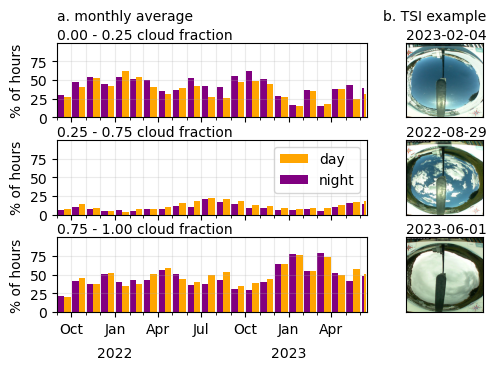

In [63]:
import matplotlib.image as mpimg


fig,axx=plt.subplots(3,2, gridspec_kw={"width_ratios":[4,1]}, figsize=(5.5, 3.5))# sharex=True)
k=0

ax00 = axx[0,0]
ax0 = axx[1,0]
ax1 = axx[2,0]
########
k =0


for i,lim in enumerate([(0, 25), (25, 75), (75, 101)]):
    ax00 = axx[i,0]
    fxc = lambda x: cfrac_by_threshold(x, lim[0], lim[1])
    dfx = resamp_midpoint(master_df, "1m", fxc).apply(pd.Series)

    mwidth = np.array([days_in_month(y, m) for y,m in zip(dfx.index.year, dfx.index.month)] )
    mwidth[-1] = 9

    ax00.bar(dfx.index, width=mwidth/2*.9 ,   height=dfx[0]*100,      color='orange', align='edge', label='day')
    ax00.bar(dfx.index, width=-mwidth/2*.9,  height=dfx[1]*100,      color='purple', align='edge', label='night')


axx[1,0].legend()



for i, axz in enumerate([axx[0,0], axx[1,0], axx[2,0]]):
    axz.set_ylabel("% of hours")
    axz.grid(alpha=.5)
    if i < 2:
        axz.set_xticklabels([])
    axz.set_ylim(0,100)
    axz.set_yticks([0, 25, 50, 75])

for i, axz in enumerate([axx[0,1], axx[1,1], axx[2,1]]):
    axz.set_xticks([])
    axz.set_yticks([])


axx[0,0].text(0, 1.30, r"a. monthly average", transform=axx[0,0].transAxes)
axx[0,0].text(0, 1.05, "0.00 - 0.25 cloud fraction",   transform=axx[0,0].transAxes)
axx[1,0].text(0, 1.05, "0.25 - 0.75 cloud fraction",   transform=axx[1,0].transAxes)
axx[2,0].text(0, 1.05, "0.75 - 1.00 cloud fraction", transform=axx[2,0].transAxes)



# # Plot the image
axx[0,1].imshow(mpimg.imread('gshare2/will_data/guctsiskycoverM1.b1.noon_image.20230204.jpg'), aspect='auto')
axx[1,1].imshow(mpimg.imread('gshare2/will_data/guctsiskycoverM1.b1.noon_image.20220829.jpeg'), aspect='auto')
axx[2,1].imshow(mpimg.imread('gshare2/will_data/guctsiskycoverM1.b1.noon_image.20230601.jpg'), aspect='auto')


axx[0,1].text(-.3, 1.30, "b. TSI example", transform=axx[0,1].transAxes)
axx[0,1].text(0, 1.05, "2023-02-04",   transform=axx[0,1].transAxes)
axx[1,1].text(0, 1.05, "2022-08-29", transform=axx[1,1].transAxes)
axx[2,1].text(0, 1.05, "2023-06-01", transform=axx[2,1].transAxes)


# fig.subplots_adjust(hspace=.3, wspace=.075)




##### FIX THE TIMES #####

major_locator = mdates.MonthLocator(bymonth=[10, 1, 4, 7])  # Major ticks every 1 day
minor_locator = mdates.MonthLocator(bymonth=range(13))            # Minor ticks every 6 hours
major_formatter = mdates.DateFormatter('%b')                      # Format major ticks as 'YYYY-MM-DD'
minor_formatter = mdates.DateFormatter('')                        # Format minor ticks as 'HH:MM'

for i in range(3):
    axz = axx[i,0]
    axz.xaxis.set_major_locator(major_locator)
    axz.xaxis.set_minor_locator(minor_locator)
    axz.xaxis.set_major_formatter(major_formatter)
    axz.xaxis.set_minor_formatter(minor_formatter)
    for tick in axz.xaxis.get_major_ticks():
        tick.label1.set_horizontalalignment('center')
        tick.label1.set_rotation('horizontal')
    axz.grid(alpha=.25, which='both')
    axz.set_xlim(pd.to_datetime("2021-09-01"), pd.to_datetime("2023-06-15"))


for i in range(2):
    axz = axx[i,0]
    axz.set_xticklabels([])
# label the year 


axx[-1,0].text(pd.to_datetime("2022-01-01 00:00:00"), -60, "2022", color='black', horizontalalignment='center')
axx[-1,0].text(pd.to_datetime("2023-01-01 00:00:00"), -60, "2023", color='black', horizontalalignment='center')



plt.subplots_adjust(hspace=.3)
plt.savefig("/global/homes/r/rudisill/gshare2/will_data/cre_project_images/FigureX_day_night_cloud_freq", dpi=300,  bbox_inches="tight")


### look at diel cycle

In [64]:
warmcloud = cloud_present_kolias_lt_6000[cloud_present_kolias_lt_6000.index.month.isin([4,5,6,7,8,9])].shift(-7, freq='1h')
coldcloud = cloud_present_kolias_lt_6000[cloud_present_kolias_lt_6000.index.month.isin([10,11,12,1,2,3])].shift(-7, freq='1h')

In [65]:
k=0
bootstraplist_sq = []
for g in coldcloud.groupby(coldcloud.index.hour):
    j=0
    bootstraplist = []
    for n in range(100):
        bootstraplist.append(g[1].sample(250).mean().values)
        j+=1        
    bootstraplist_sq.append(bootstraplist)
#    ax.boxplot(np.array(bootstraplist), positions=[k], widths=0.5, patch_artist=True, showfliers=False)
    k+=1


k=0
bootstraplist_sq2 = []
for g in warmcloud.groupby(warmcloud.index.hour):
    j=0
    bootstraplist = []
    for n in range(100):
        bootstraplist.append(g[1].sample(250).mean().values)
        j+=1        
#    ax.boxplot(np.array(bootstraplist), positions=[k], widths=0.5, patch_artist=True, showfliers=False, boxprops=dict(facecolor="red"))
    bootstraplist_sq2.append(bootstraplist)
    k+=1


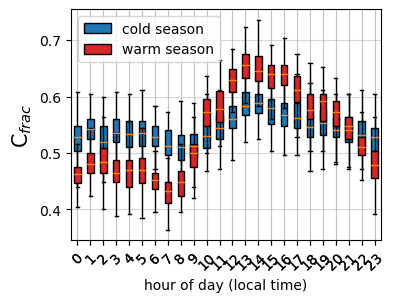

In [69]:
fig, ax = plt.subplots(figsize=(4,3))
for i,bs in enumerate(bootstraplist_sq):
    bp1=ax.boxplot(np.array(bs), positions=[i], widths=0.5, patch_artist=True, showfliers=False, boxprops=dict(facecolor="tab:blue"))

for i,bs in enumerate(bootstraplist_sq2):
    bp2=ax.boxplot(np.array(bs), positions=[i], widths=0.5, patch_artist=True, showfliers=False, boxprops=dict(facecolor="tab:red"))

leg=ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['cold season', 'warm season'], loc='upper left')
ax.set_xlabel("hour of day (local time)")
ax.set_ylabel(r"C$_{frac}$", fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(alpha=.5)
plt.savefig("/global/homes/r/rudisill/gshare2/will_data/cre_project_images/FigureX_diel_cloud_freq", dpi=300,  bbox_inches="tight")
